# Analyze MDCK on gel for throughput  

Data:
- Nucleus:  
  id551_MDCK_unit_acousticon_sheathon_01_200Hz_405_250mW_488_150mW_405_reconstructed_cropped.tif
- Segmented spheroid: id551_MDCK_unit_acousticon_sheathon_01_200Hz_405_250mW_488_150mW_488_reconstructed_cropped_segmented_spheroids.npy

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tifffile

from skimage.transform import rescale
from skimage.measure import regionprops_table, marching_cubes, mesh_surface_area
from skimage.morphology import remove_small_objects
from skimage.segmentation import clear_border
from skimage.filters import unsharp_mask

from cellpose import models, core
from cellpose import plot

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

# call logger_setup to have output of cellpose written
from cellpose.io import logger_setup
logger_setup();

>>> GPU activated? 1
2023-06-15 20:18:53,659 [INFO] WRITING LOG OUTPUT TO /home/minato/.cellpose/run.log


## Functions

In [9]:
def segment(data):
    '''
    Segment nucleus

    data: name of the input data of nucleus
    '''
    img = tifffile.imread(f'../result/{data}')
    img = rescale(img, 0.5, anti_aliasing=True)
    img = img[:, 10:630, :]
    img = (img - img.min()) / (img.max() - img.min())
    img = unsharp_mask(img, radius=5, amount=10)

    model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
    channels = [0,0]
    masks, flows, styles, _ = model.eval(img, channels=channels, diameter=17, do_3D=True)

    return masks

In [11]:
def filter(segmented, spheroid):
    '''
    Filter out nuclei in spheroids without beads

    segmented: label image of nuclei after segmentation
    spheroid: name of the data of segmented spheroids
    '''
    spheroid = np.load(f'../result/{spheroid}')
    spheroid = spheroid>0 # select area of spheroids
    retained_labels = np.unique(segmented[spheroid]) # find labels of nucleus inside spheroids
    res = np.where(np.isin(segmented, retained_labels), segmented, 0) # retain labels inside spheroids

    return res

In [7]:
def calculate_props(segmented, scale=(None, None, None)):
    '''
    Calculate morphological properties of nucleus

    data: name of the input data
    segmented: label image after segmentation
    scale: pixel resolution in um scale
    res = []
    surface = []
    '''
    segmented = clear_border(segmented) # remove objects on the edge
    segmented = remove_small_objects(segmented, min_size=125) # remove small objects
    props = pd.DataFrame(regionprops_table(segmented, properties=('label', 'area', 'axis_major_length', 'axis_minor_length', 'solidity', 'bbox'),
                                       spacing=scale))
    props = props.rename(columns={'area': 'Volume', 'axis_major_length': 'Major axis length', 'axis_minor_length': 'Minor axis length', 'solidity': 'Solidity'})
    props['Aspect ratio'] = props['Major axis length']/props['Minor axis length']
    
    for i, row in props.iterrows():
        label = row['label']
        bbox = np.array((row['bbox-0'], row['bbox-3'], row['bbox-1'], row['bbox-4'], row['bbox-2'], row['bbox-5']), dtype='uint64')
        labelled_object = data[bbox[0]:bbox[1], bbox[2]:bbox[3], bbox[4]:bbox[5]]
        labelled_object = np.where(labelled_object==label, True, False)

        verts, faces, _, _ = marching_cubes(labelled_object, spacing=scale)
        surface = mesh_surface_area(verts, faces)
        
    
    props['Surface area'] = surface
    props['Surface-to-Volume'] = surface/props['Volume']
    
    return props

In [10]:
nucleus = 'id551_MDCK_unit_acousticon_sheathon_01_200Hz_405_250mW_488_150mW_405_reconstructed_cropped.tif'
spheroid = 'id551_MDCK_unit_acousticon_sheathon_01_200Hz_405_250mW_488_150mW_488_reconstructed_cropped_segmented_spheroids.npy'

In [8]:
res = segment(nucleus)


2023-06-15 20:19:16,969 [INFO] ** TORCH CUDA version installed and working. **
2023-06-15 20:19:16,972 [INFO] >>>> using GPU
2023-06-15 20:19:16,974 [INFO] >> nuclei << model set to be used
2023-06-15 20:19:17,337 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2023-06-15 20:19:17,341 [INFO] ~~~ FINDING MASKS ~~~
2023-06-15 20:19:17,441 [INFO] multi-stack tiff read in as having 100 planes 1 channels
2023-06-15 20:19:20,408 [INFO] running YX: 100 planes of size (620, 476)
2023-06-15 20:19:35,521 [INFO] 100%|##########| 34/34 [00:14<00:00,  2.28it/s]
2023-06-15 20:19:36,681 [INFO] running ZY: 620 planes of size (100, 476)
2023-06-15 20:19:47,941 [INFO] 100%|##########| 57/57 [00:11<00:00,  5.16it/s]
2023-06-15 20:19:49,508 [INFO] running ZX: 476 planes of size (100, 620)
2023-06-15 20:20:00,343 [INFO] 100%|##########| 60/60 [00:10<00:00,  5.64it/s]
2023-06-15 20:20:01,954 [INFO] network run in 44.07s
2023-06-15 20:20:24,929 [INFO] masks created in 22.9

In [9]:
print(np.unique(res))

[   0    1    2 ... 1689 1690 1691]


In [10]:
res_filtered = filter(res, spheroid)

In [11]:
print(len(np.unique(res_filtered)))

619


In [14]:
# spatial resolution in um scale
scale = np.repeat(0.295*4, 3)

In [15]:
res_props = calculate_props(res_filtered, scale=scale)

In [16]:
res_props

,label,Volume,Major axis length,Minor axis length,Solidity,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,Aspect ratio,Surface area,Surface-to-Volume
0,1,568.489072,15.924257,7.272601,0.858561,28,47,72,40,54,81,2.189624,241.693439,0.425151
1,2,721.291048,14.394144,9.939447,0.837786,28,110,134,38,120,143,1.448183,322.886707,0.447651
2,3,680.215248,12.343161,9.994696,0.920000,28,120,144,36,128,153,1.234971,147.930493,0.217476
3,4,361.467040,10.968340,7.203707,0.887097,29,19,439,38,25,446,1.522597,126.464934,0.349866
4,5,325.320336,11.197428,7.250331,0.838983,29,105,146,37,113,153,1.544402,184.430736,0.566920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,509,374.611296,9.921859,7.933667,0.912000,64,509,289,72,516,296,1.250602,130.570707,0.348550
509,510,695.002536,12.973157,9.225095,0.884937,65,519,224,75,527,234,1.406290,294.642887,0.423945
510,511,478.122312,11.101561,8.635785,0.944805,66,356,157,73,363,165,1.285530,87.956038,0.183961
511,512,644.068544,11.789212,9.808297,0.940048,67,109,304,75,117,312,1.201963,108.763070,0.168869


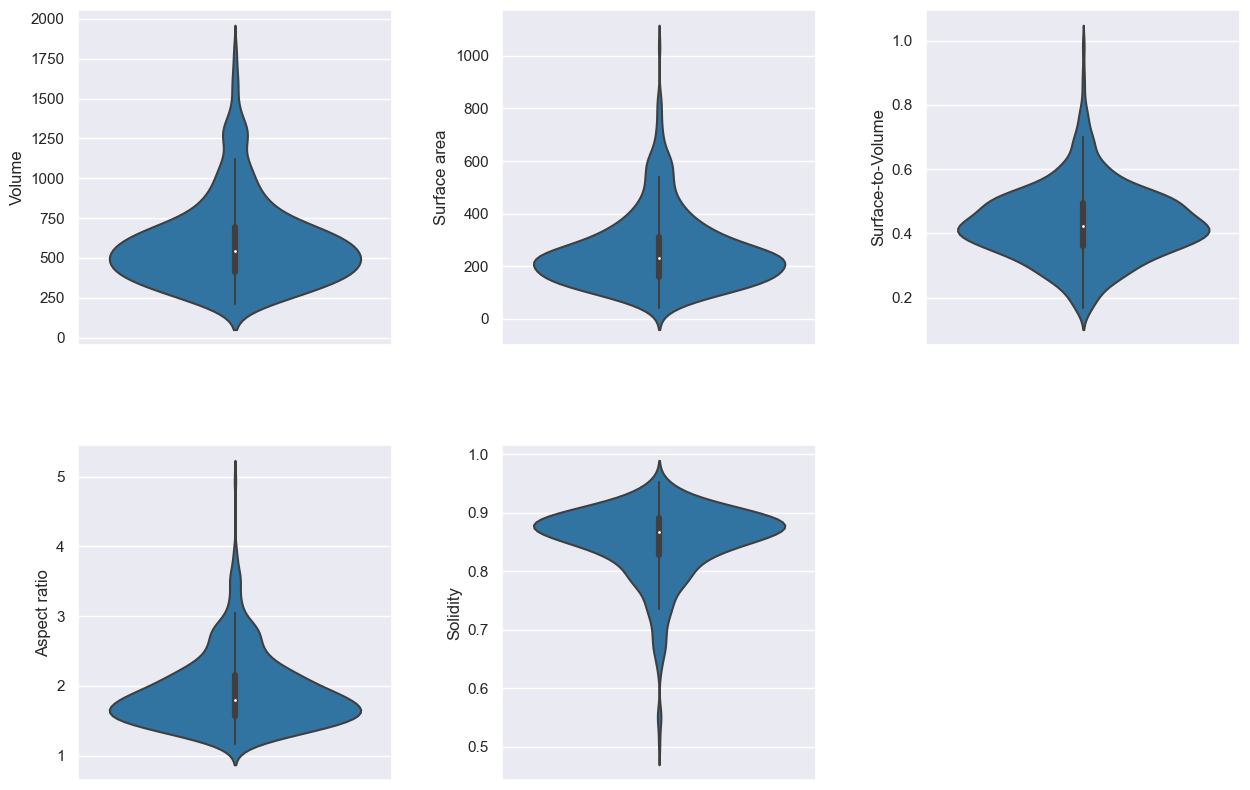

In [17]:
sns.set_style('darkgrid')
sns.set_context('notebook')

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

columns = ['Volume', 'Surface area', 'Surface-to-Volume', 'Aspect ratio', 'Solidity']

for i, ax in enumerate(axes):
    if i == 5:
        axes[i].set_axis_off()
    else:
        sns.violinplot(data=res_props, y=columns[i], ax=ax)

plt.subplots_adjust(wspace=0.35, hspace=0.3)
#plt.suptitle(f'Morphological properties of nucleus n={n_adhered}(adhered), {n_suspended}(suspended)', y=0.95, size=20)

In [20]:
res_props.to_csv('../result/ongel_on_on_1_200fps_props.csv')